# Comparison of Louvaine and Leiden algorithms for given datasets

## Imports

In [1]:
!pip install -qr requirements.txt

DEPRECATION: Loading egg at /opt/homebrew/Cellar/tbb/2021.12.0/lib/python3.12/site-packages/TBB-0.2-py3.12-macosx-13.0-arm64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: /opt/homebrew/opt/python@3.12/bin/python3.12 -m pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
import pandas as pd
import numpy as np
import math

# graph related library
import networkx as nx
import leidenalg
import igraph as ig
import community.community_louvain as community_louvain
import networkx.algorithms.community as nx_comm
import networkx as nx
import scipy

## Load data

### Karate club dataset. (nx.karate_club_graph())

Zachary's karate club is a social network of a university karate club, described in the paper "An Information Flow Model for Conflict and Fission in Small Groups" by Wayne W. Zachary. The network became a popular example of community structure in networks.

In [3]:
karate_network = nx.karate_club_graph()

### [University email addresses dataset](https://networkrepository.com/email-univ.php)

In [4]:
univ_network = nx.read_edgelist("data/email_univ.edges")

### [Enron email addresses dataset](https://networkrepository.com/email-enron-only.php)

In [5]:
# Load the Matrix Market file
enron_matrix = scipy.io.mmread("data/email_enron_only.mtx")

# Convert the sparse matrix to a NetworkX graph
enron_network = nx.from_scipy_sparse_array(enron_matrix)

## Describe data

In [6]:
def get_graph_info(graph):
    print("Number of nodes:", graph.number_of_nodes())
    print("Number of edges:", graph.number_of_edges())
    print(f"Average Cluster Coefficients: {nx.average_clustering(graph):.2%}")
    print("Connected components:", len(list(nx.connected_components(graph))))

In [7]:
# karate
get_graph_info(karate_network)

Number of nodes: 34
Number of edges: 78
Average Cluster Coefficients: 57.06%
Connected components: 1


We have 34 nodes and 78 edges. Overall, the probability of adjacent nodes being connected is 57.06%. The graph is connected with no separation because we have 1 connected component.

In [8]:
# univ
get_graph_info(univ_network)

Number of nodes: 1133
Number of edges: 5451
Average Cluster Coefficients: 22.02%
Connected components: 1


We have 1133 nodes and 5451 edges. Overall, the probability of adjacent nodes being connected is 22.02%. The graph is connected with no separation because we have 1 connected component.

In [9]:
# enron
get_graph_info(enron_network)

Number of nodes: 143
Number of edges: 623
Average Cluster Coefficients: 43.39%
Connected components: 1


We have 143 nodes and 623 edges. Overall, the probability of adjacent nodes being connected is 43.39%. The graph is connected with no separation because we have 1 connected component.

## Analyze data

In [10]:
def convert_communities_dict_to_list(communities_dict):
    """
    Convert community dictionary to a list of community node lists.
    Made for Louvain output and Leiden output.
    """
    communities = {}
    for node, community in communities_dict.items():
        communities.setdefault(community, []).append(node)
    print(f"Number of communities: {len(communities)}")
    return list(communities.values())

In [11]:
def check_community_disconnection(graph, communities):
    """
    Function to check whether the determined communities are connected
    """
    total_connected = 0
    disconnected_community_indexes = []
    for i in range(len(communities)):
        if nx.is_connected(graph.subgraph(communities[i])):
            total_connected += 1
        else:
            disconnected_community_indexes.append(i)
    print("Total Communities:", len(communities))
    print("Total Communities Connected:", total_connected)
    print("Disconnected Community Indexes:", disconnected_community_indexes)

In [12]:
def community_size_hist(communities):
    community_sizes = pd.DataFrame([len(community) for community in communities], columns=["community_size"])
    community_sizes.plot.hist(bins=22, figsize=(8, 5), title="Community Size Distribution")
    plt.show()

In [13]:
def create_community_node_colors(graph, communities):
    number_of_colors = len(communities[0])
    colors = ["#EF9A9A", "#BA68C8", "#64B5F6", "#81C784", "#FFF176", "#BDBDBD"][:number_of_colors]
    node_colors = []

    # iterate each node in the graph and find which community it belongs to
    # if the current node is found at a specific community, add color to the
    # node_colors list
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                break
            current_community_index += 1
    return node_colors


def visualize_subgraph(dataset, index):
    # get subgraph of community with index `index`
    subgraph = dataset.subgraph(louvain_communities[index])
    components = list(nx.connected_components(subgraph))
    
    # create visualization
    node_colors = create_community_node_colors(subgraph, components)
    pos = nx.spring_layout(subgraph, iterations=50, k=0.05, seed=2)
    
    plt.figure(1, figsize=(7, 4))
    nx.draw(subgraph, pos=pos, node_size=10, width=0.5, node_color=node_colors)
    plt.title(f"Louvain Results for Community Index {index}")
    plt.show()

### Louvain Algorithm

#### Karate

In [14]:
DATASET = karate_network

In [15]:
# get best clustering
louvain_communities = community_louvain.best_partition(DATASET, random_state=0)

In [16]:
# show number of clusters
louvain_communities = convert_communities_dict_to_list(louvain_communities)

Number of communities: 4


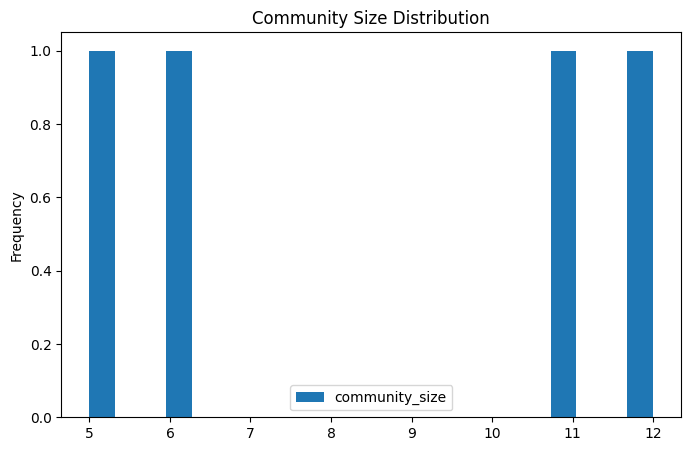

In [17]:
# visualize community sizes
community_size_hist(louvain_communities)

In [18]:
# take a look at the modularity of the Louvain algorithm output
print(f"Modularity: {nx_comm.modularity(DATASET, louvain_communities):.3f}")

Modularity: 0.445


In [19]:
check_community_disconnection(DATASET, louvain_communities)

Total Communities: 4
Total Communities Connected: 4
Disconnected Community Indexes: []


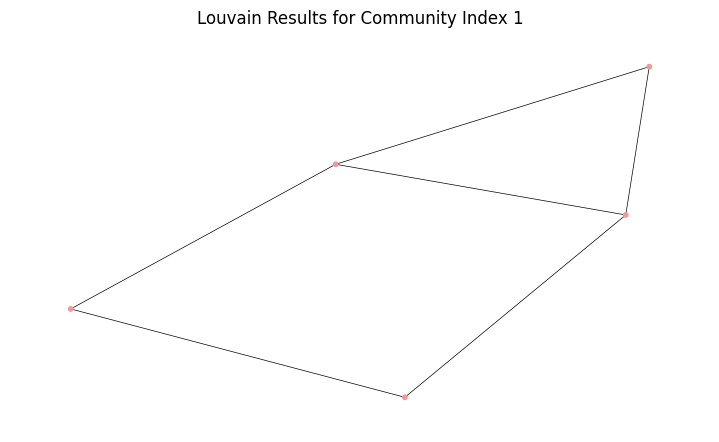

In [20]:
visualize_subgraph(DATASET, index=1)

#### Univ

In [21]:
DATASET = univ_network

In [22]:
# get best clustering
louvain_communities = community_louvain.best_partition(DATASET, random_state=0)

In [23]:
# show number of clusters
louvain_communities = convert_communities_dict_to_list(louvain_communities)

Number of communities: 11


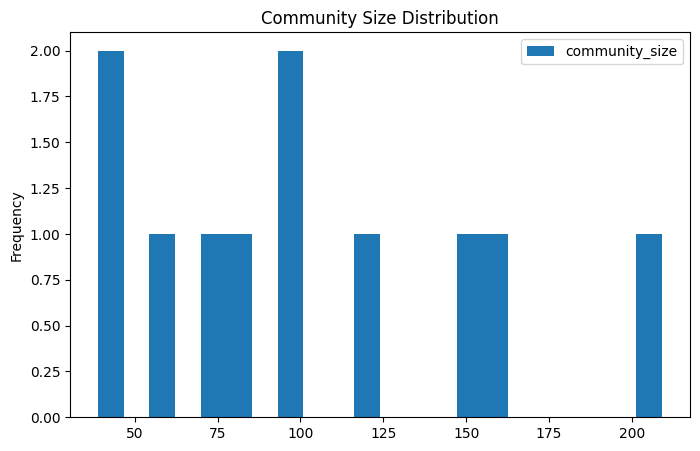

In [24]:
# visualize community sizes
community_size_hist(louvain_communities)

In [25]:
# take a look at the modularity of the Louvain algorithm output
print(f"Modularity: {nx_comm.modularity(DATASET, louvain_communities):.3f}")

Modularity: 0.565


In [26]:
check_community_disconnection(DATASET, louvain_communities)

Total Communities: 11
Total Communities Connected: 11
Disconnected Community Indexes: []


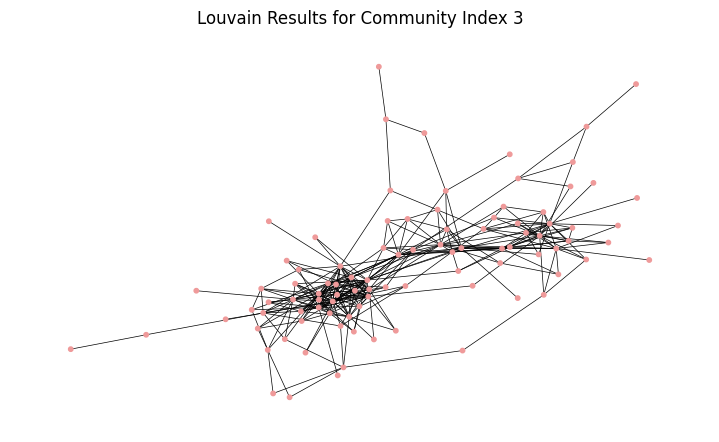

In [27]:
visualize_subgraph(DATASET, index=3)

#### Enron

In [28]:
DATASET = enron_network

In [29]:
# get best clustering
louvain_communities = community_louvain.best_partition(DATASET, random_state=0)

In [30]:
# show number of clusters
louvain_communities = convert_communities_dict_to_list(louvain_communities)

Number of communities: 7


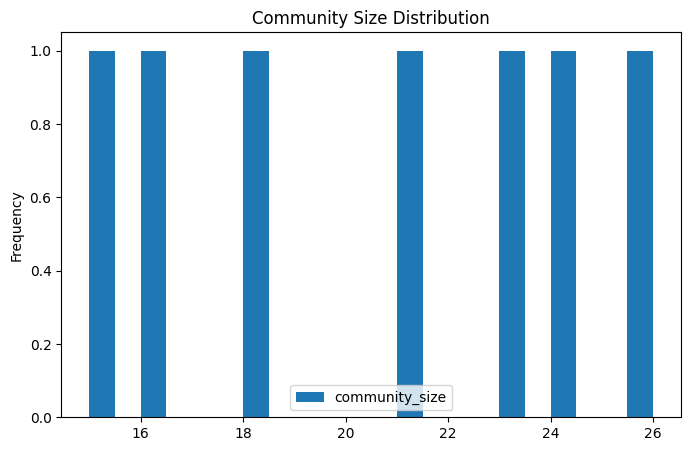

In [31]:
# visualize community sizes
community_size_hist(louvain_communities)

In [32]:
# take a look at the modularity of the Louvain algorithm output
print(f"Modularity: {nx_comm.modularity(DATASET, louvain_communities):.3f}")

Modularity: 0.568


In [33]:
check_community_disconnection(DATASET, louvain_communities)

Total Communities: 7
Total Communities Connected: 7
Disconnected Community Indexes: []


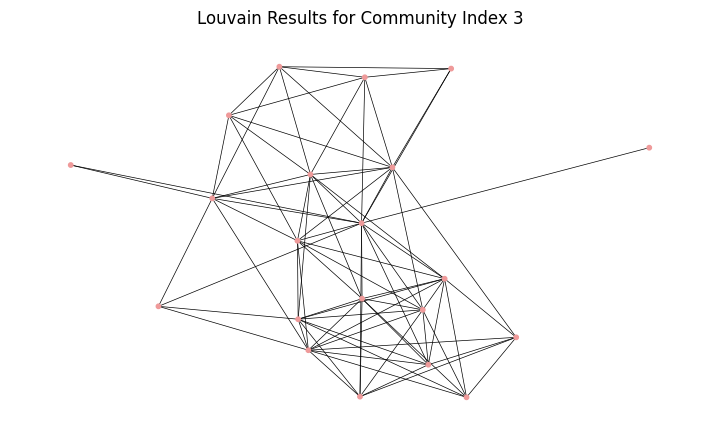

In [34]:
visualize_subgraph(DATASET, index=3)

Louvain algorithm doesn't guarantee communities are connected by itself. Leiden improved Louvain algorithm with guarantte. Let's take a look the runtime, modularity, and connectivity for Leiden algorithm.

### Leiden Algorithm

#### Karate

In [35]:
DATASET = karate_network

Because it's originally implemented in i-graph, we first need to convert NetworkX graph to i-graph to use the original implementation.

In [36]:
temp_graph = ig.Graph.from_networkx(DATASET)

In [37]:
# get best clustering
leiden_communities = leidenalg.find_partition(temp_graph, partition_type=leidenalg.ModularityVertexPartition, seed=0)

The Leiden algoirthm calculation runtime of 7.6s is much faster compared to Louvain (4 min 57s). One thing to note is the implementation of the packages. Overall, Leiden is faster. Here, the Leiden algorithm is implemented with C++ for speeding the code up.

In [38]:
# show number of clusters
leiden_communities_dict = dict(zip(temp_graph.vs["_nx_name"], leiden_communities.membership))
leiden_communities_list = convert_communities_dict_to_list(leiden_communities_dict)

Number of communities: 4


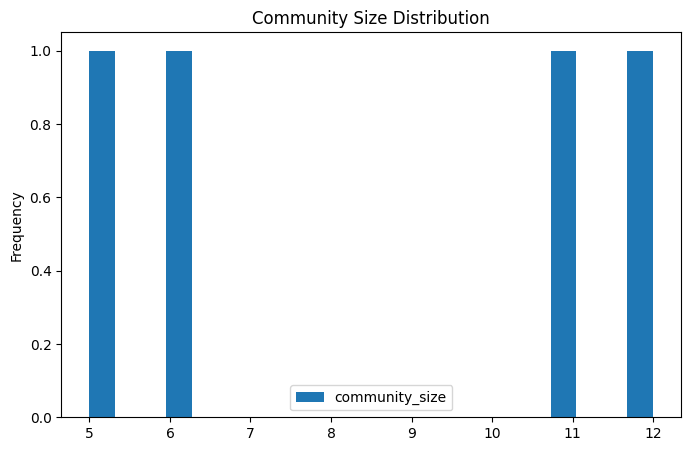

In [39]:
community_size_hist(leiden_communities_list)

In [40]:
# take a look at the modularity of the Leiden algorithm output
print(f"Modularity: {nx_comm.modularity(DATASET, leiden_communities_list):.3f}")

Modularity: 0.445


The modularity score of 0.445 is the same as for Louvain.

In [41]:
check_community_disconnection(DATASET, leiden_communities_list)

Total Communities: 4
Total Communities Connected: 4
Disconnected Community Indexes: []


No disconnected community in Leiden's output.

#### Univ

In [42]:
DATASET = univ_network

Because it's originally implemented in i-graph, we first need to convert NetworkX graph to i-graph to use the original implementation.

In [43]:
temp_graph = ig.Graph.from_networkx(DATASET)

In [44]:
# get best clustering
leiden_communities = leidenalg.find_partition(temp_graph, partition_type=leidenalg.ModularityVertexPartition, seed=0)

The Leiden algoirthm calculation runtime of 7.6s is much faster compared to Louvain (4 min 57s). One thing to note is the implementation of the packages. Overall, Leiden is faster. Here, the Leiden algorithm is implemented with C++ for speeding the code up.

In [45]:
# show number of clusters
leiden_communities_dict = dict(zip(temp_graph.vs["_nx_name"], leiden_communities.membership))
leiden_communities_list = convert_communities_dict_to_list(leiden_communities_dict)

Number of communities: 10


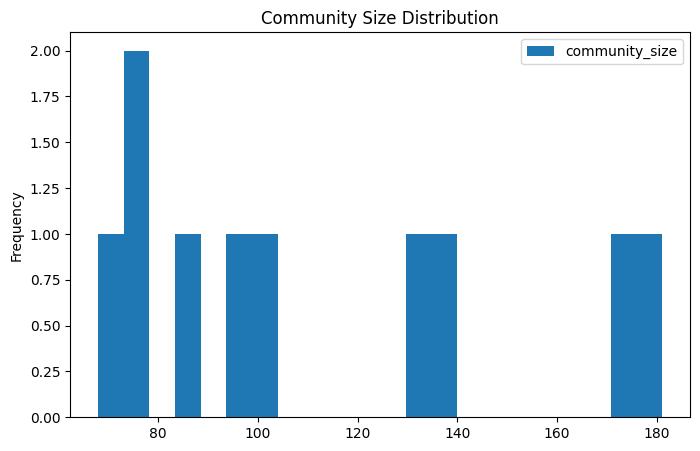

In [46]:
community_size_hist(leiden_communities_list)

In [47]:
# take a look at the modularity of the Leiden algorithm output
print(f"Modularity: {nx_comm.modularity(DATASET, leiden_communities_list):.3f}")

Modularity: 0.581


The modularity score of 0.445 is the same as for Louvain.

In [48]:
check_community_disconnection(DATASET, leiden_communities_list)

Total Communities: 10
Total Communities Connected: 10
Disconnected Community Indexes: []


No disconnected community in Leiden's output.

#### Enron

In [49]:
DATASET = enron_network

Because it's originally implemented in i-graph, we first need to convert NetworkX graph to i-graph to use the original implementation.

In [50]:
temp_graph = ig.Graph.from_networkx(DATASET)

In [51]:
# get best clustering
leiden_communities = leidenalg.find_partition(temp_graph, partition_type=leidenalg.ModularityVertexPartition, seed=0)

The Leiden algoirthm calculation runtime of 7.6s is much faster compared to Louvain (4 min 57s). One thing to note is the implementation of the packages. Overall, Leiden is faster. Here, the Leiden algorithm is implemented with C++ for speeding the code up.

In [52]:
# show number of clusters
leiden_communities_dict = dict(zip(temp_graph.vs["_nx_name"], leiden_communities.membership))
leiden_communities_list = convert_communities_dict_to_list(leiden_communities_dict)

Number of communities: 7


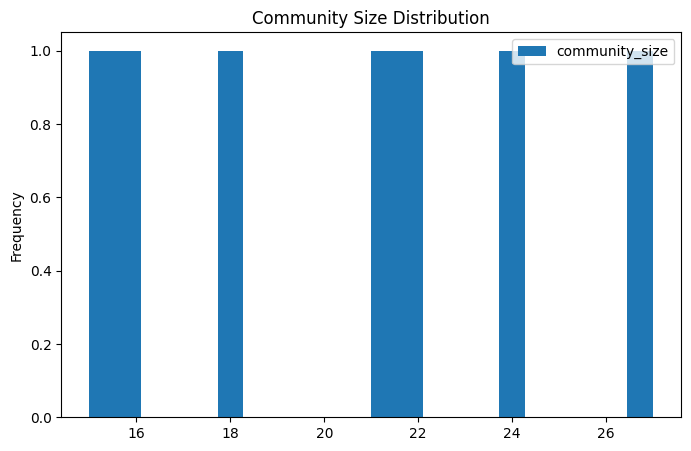

In [53]:
community_size_hist(leiden_communities_list)

In [54]:
# take a look at the modularity of the Leiden algorithm output
print(f"Modularity: {nx_comm.modularity(DATASET, leiden_communities_list):.3f}")

Modularity: 0.565


The modularity score of 0.445 is the same as for Louvain.

In [55]:
check_community_disconnection(DATASET, leiden_communities_list)

Total Communities: 7
Total Communities Connected: 7
Disconnected Community Indexes: []


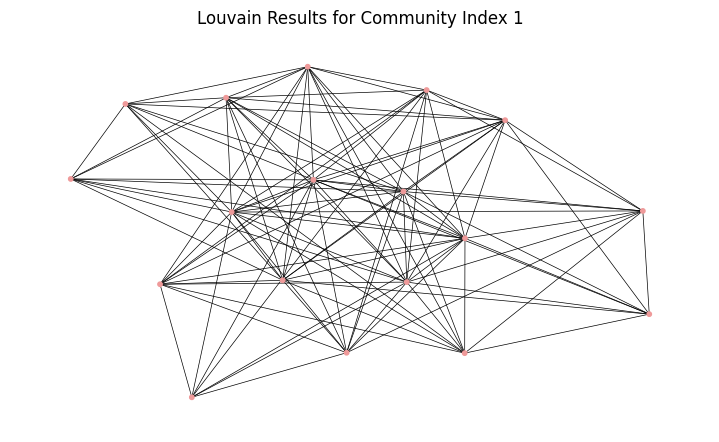

In [56]:
visualize_subgraph(DATASET, index=1)